# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [2]:
names = {'student_1': "Fredrik Bixo",
        'student_2': "Ann Onymous"}

sciper = {'student_1': 300685, 
          'student_2': 888888}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [3]:
conversations = getRawDataFromFile()
print(conversations[0])
print(conversations[1])

['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .', 'you must be very fast . hunting is one of my favorite hobbies .', 'i am ! for my hobby i like to do canning or some whittling .', 'i also remodel homes when i am not out bow hunting .', 'that is neat . when i was in high school i placed 6th in 100m dash !', 'that is awesome . do you have a favorite season or time of year ?', 'i do not . but i do have a favorite meat since that is all i eat exclusively .', 'what is your favorite meat to eat ?', 'i would have to say its prime rib . do you have any favorite foods ?', 'i like chicken or macaroni and cheese .', 'do you have anything planned for today ? i think i am going to do some canning .', 'i am going to watch football . what are you canning ?', 'i think i will can some jam . do you also play footfall for fun ?', 'if i have time outside of hunting and remodeling homes . which is not much !']
['hi , how are you doing today ?', 'i am spending ti

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**



In [72]:
frequencies = {} 

for conversation in conversations:
    for sentance in conversation:
        words = sentance.split(' ')
        for word in words:
            if word not in frequencies:
                frequencies[word] = 0
            frequencies[word] += 1

In [65]:
print(frequencies)

{'i': 9994, 'like': 1700, 'chicken': 27, 'or': 198, 'macaroni': 3, 'and': 1590, 'cheese': 28, '.': 9928, 'that': 2103, 'is': 2938, 'cool': 437, 'my': 2657, 'mom': 142, 'does': 157, 'the': 2098, 'same': 76, 'thing': 74, 'just': 542, 'drink': 51, 'some': 259, 'cola': 2, 'with': 723, 'rum': 1, 'you': 4142, 'will': 403, 'forget': 8, 'about': 459, 'them': 339, '!': 2138, 'better': 96, 'not': 1497, 'make': 202, 'any': 384, 'spelling': 2, 'mistakes': 1, 'doubt': 9, 'very': 316, 'much': 278, 'probably': 62, 'to': 3236, 'scream': 4, 'alone': 43, 'parents': 116, 'do': 3105, 'know': 246, 'am': 1831, 'homosexual': 1, 'no': 543, 'work': 590, 'at': 536, 'a': 3318, 'funeral': 5, 'home': 134, 'own': 116, 'it': 1527, 'think': 224, 'there': 284, 'confusion': 2, '?': 3596, 'maybe': 193, 'can': 450, 'borrow': 3, 'something': 80, 'as': 374, 'packing': 2, 'visit': 55, 'dad': 101, 'in': 1352, 'china': 8, 'trying': 57, 'get': 358, 'ba': 2, 'finance': 3, 'fun': 353, 'cant': 37, 'enough': 44, 'bank': 6, 'teller

In [66]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
top75words = sortedWords[:75]
bottom75words = sortedWords[len(sortedWords)-75:]
print(top75words)

['i', '.', 'you', '?', ',', 'a', 'to', 'do', 'is', 'my', '!', 'that', 'the', 'have', 'am', 'like', 'and', 'it', 'not', 'in', 'what', 'of', 'are', 'for', 'love', 'but', 'me', 'so', 'with', 'too', 'be', 'your', 'work', 'no', 'just', 'at', 'good', 'yes', 'on', 'would', 'oh', 'about', 'favorite', 'can', 'cool', 'time', 'go', 'really', 'they', 'will', 'well', 'was', 'nice', 'any', 'as', 'how', 'all', 'get', 'fun', 'them', 'we', 'great', 'very', 'one', 'an', 'sounds', 'lot', 'from', 'out', 'music', 'live', 'there', 'its', 'much', 'when']


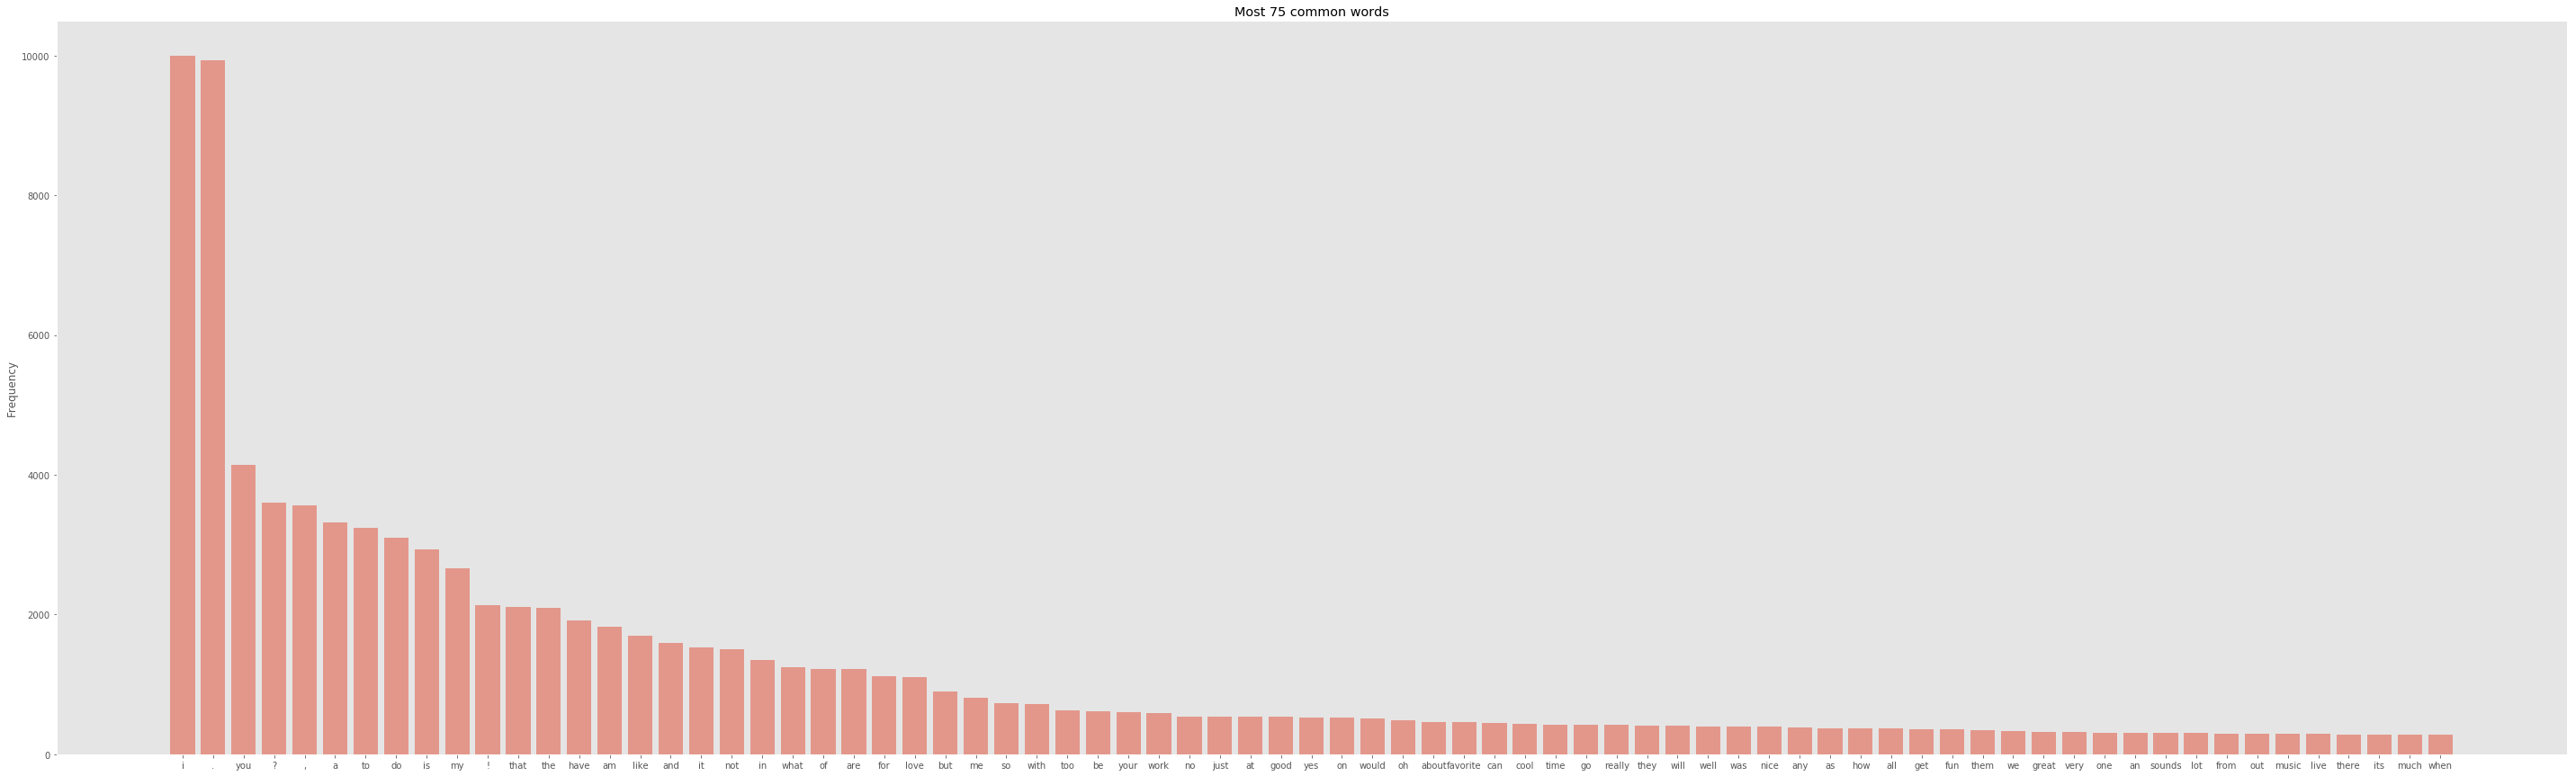

In [67]:
y_pos = np.arange(len(top75words))
performance = [frequencies[k] for k in top75words]

plt.figure(figsize=(50,15))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, top75words)
plt.ylabel('Frequency')
plt.title('Most 75 common words')

plt.show()

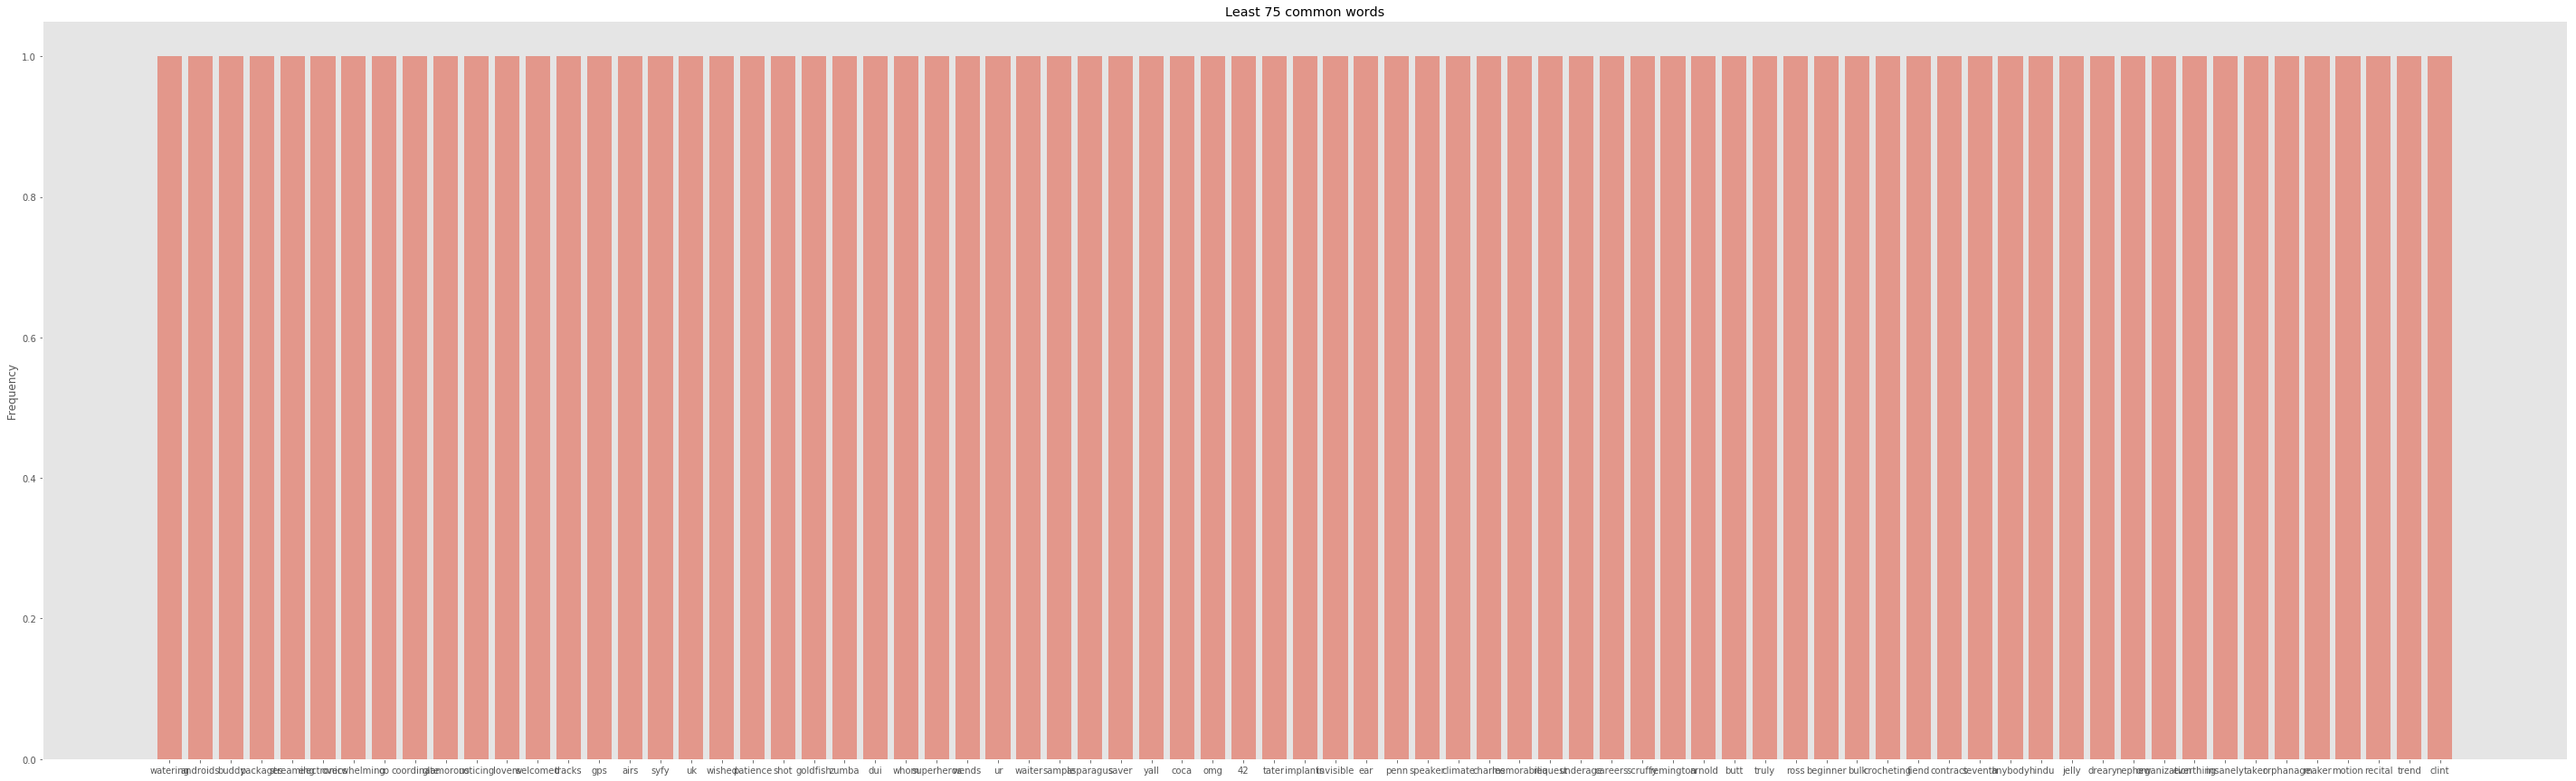

In [68]:
y_pos = np.arange(len(top75words))
performance = [frequencies[k] for k in bottom75words]

plt.figure(figsize=(50,15))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, bottom75words)
plt.ylabel('Frequency')
plt.title('Least 75 common words')

plt.show()

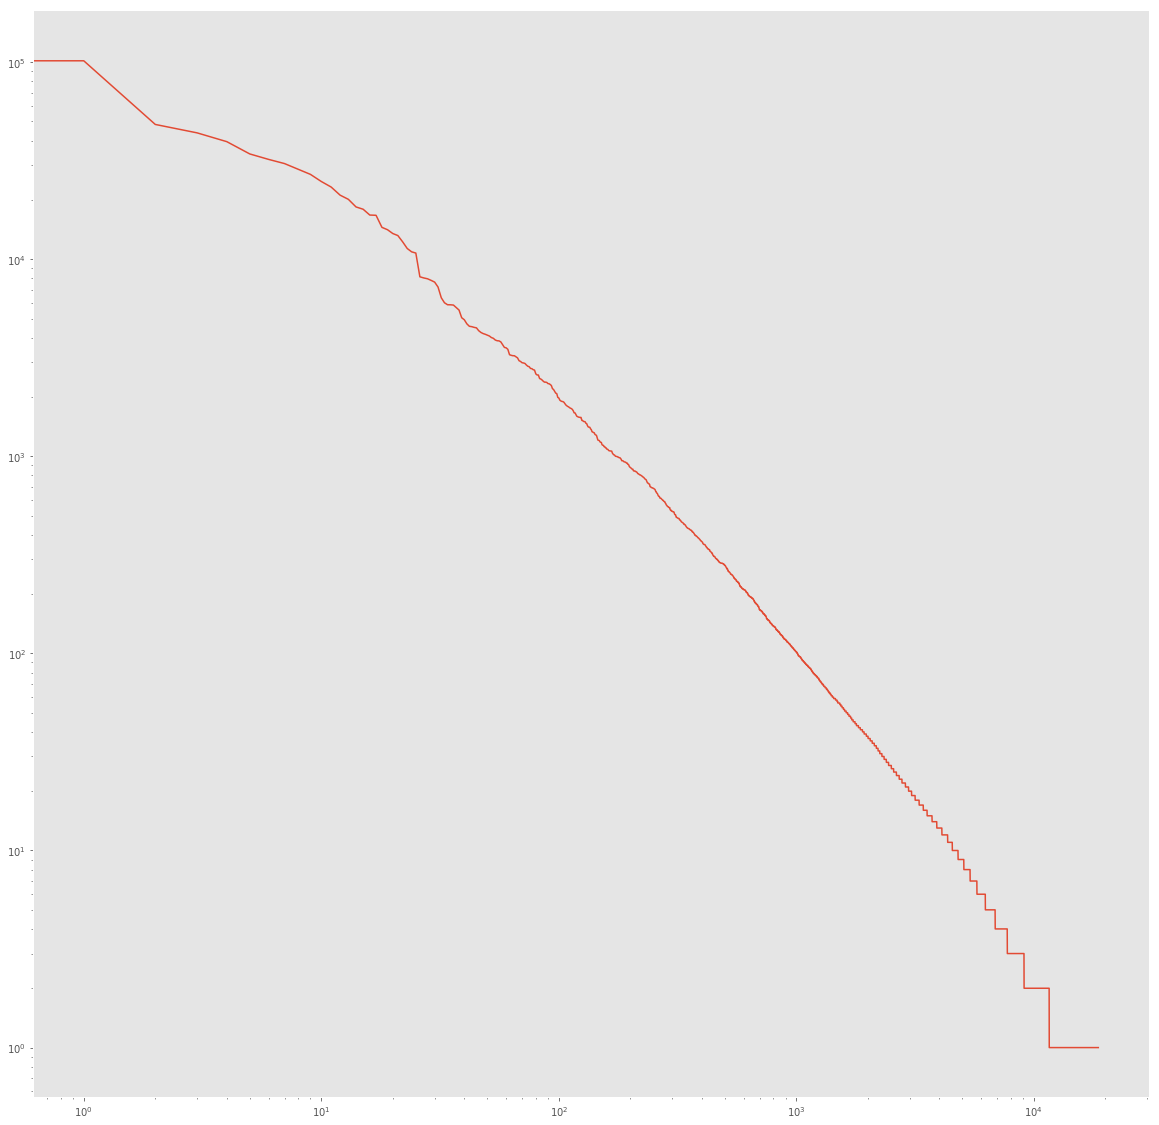

In [78]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)

x = []
y = []
i = 0
for word in sortedWords:
    y.append(frequencies[word])
    x.append(i)
    i += 1 
    
plt.figure(figsize=(20,20))
plt.loglog(x, y)

Since the graph is almost linear we can see that the word count follows a zipf distrubition. In other words, the most common word frequency is inversy proportional. So the most common word is multiplicative of the second most common word and so on.  

In [80]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
performance = [frequencies[k] for k in sortedWords]

y = 0
for i in performance:
    if i == 1:
        y += 1
        
print(y)

7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**:

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: 

In [115]:
N = 70

original_sentances = 0
filtered_sentances = 0
new_conversations = getRawDataFromFile("personachat/",  "train_both_revised.txt")

frequencies = {} 

for conversation in new_conversations:
    for sentance in conversation:
        original_sentances += 1
        words = sentance.split(' ')
        for word in words:
            if word not in frequencies:
                frequencies[word] = 0
            frequencies[word] += 1

for conversation in new_conversations:
    for sentance in conversation:
        words = sentance.split(' ')
        for word in words:
            if frequencies[word] <= N:
                conversation.remove(sentance)
                break     
            
new_frequencies = {}
                
for conversation in new_conversations:
    for sentance in conversation:
        filtered_sentances += 1
        words = sentance.split(' ')
        for word in words:
            if word not in new_frequencies:
                new_frequencies[word] = 0
            new_frequencies[word] += 1
            

print('old number of words:', len(frequencies)) 
print('new number of words:',len(new_frequencies))                       
print('old number of sentances:',original_sentances)       
print('new number of sentances:',  filtered_sentances) 


old number of words: 18673
new number of words: 12312
old number of sentances: 131424
new number of sentances: 84392


TODO:

By removing rare sentances with rare words, you may get better generalization before data points that are extreme and unusual are not considered. 

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your I’m dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [174]:
new_conversations = getRawDataFromFile("personachat/",  "train_both_revised.txt")

tokenized_conversations = []
sentances = []
sentance_lengths = []

dictionary = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
dictionary.insert(0,'START')
dictionary.insert(0,'END')
dictionary.insert(0,'PADD')

tokens = []

for x in range(len(dictionary)):
    tokens.append(x)

for conversation in new_conversations:
    new_conversation = []
    for sentance in conversation:
        words = sentance.split(' ')
        new_sentance = []
        new_sentance.append(dictionary.index('START'))
        for word in words:
            new_sentance.append(dictionary.index(word))
        new_sentance.append(dictionary.index('END'))
        sentance_lengths.append(len(new_sentance)-2)
        sentances.append(new_sentance)
        new_conversation.append(new_sentance)
    tokenized_conversations.append(new_conversation)

print(len(tokenized_conversations))

8938


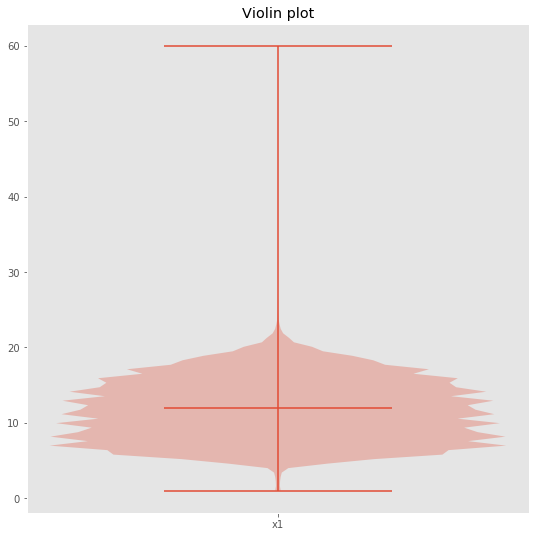

In [163]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))

# Fixing random state for reproducibility
np.random.seed(19680801)

# plot violin plot
axes.violinplot(sentance_lengths,
                   showmeans=False,
                   showmedians=True)
axes.set_title('Violin plot')

# add x-tick labels
plt.setp(axes, xticks=[1],
         xticklabels=['x1'])
plt.show()

In [168]:
filtered_sentences = pad_sequences(sentances, maxlen=60, dtype='int32', padding='pre', truncating='pre', value=0.0)

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [173]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered_sentences, dictionary, tokens], file)
    
#load
with open("data.pkl", "rb") as file:
    [filtered_sentences, dictionary, tokens] = pickle.load(file)
    
print(tokens)

range(0, 18676)


## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

In [ ]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [ ]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [ ]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")

#your network here
H['RNN'] = #... Recurrent layer(s)

R['RNN'] = #... Readout
Y['RNN'] = #... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [ ]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [ ]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()
